In [25]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [26]:
file_path = "Herrera_et_al_2021_JEP_LMC.xlsx"

# Load all sheets to check the structure
xls = pd.ExcelFile(file_path)
xls.sheet_names


['Exp1a',
 'Exp1aRaw',
 'Exp1b',
 'Exp1bRaw',
 'Exp1c',
 'Exp1cRaw',
 'Exp2',
 'Exp2Raw',
 'Exp3a',
 'Exp3aRaw',
 'Exp3b',
 'Exp3bRaw',
 'Exp4',
 'Exp4Raw',
 'Exp5',
 'Exp1SuplementaryMaterial',
 'Exp2SuplementaryMaterial',
 'Meta_StrongContiguity',
 'Meta_WeakContiguity']

In [27]:
# Step 2: List of spatial experiment sheets
spatial_sheets = ['Exp5', 'Exp1SuplementaryMaterial', 'Exp2SuplementaryMaterial']

# Step 3: Load spatial data into dictionary
spatial_data = {sheet: xls.parse(sheet) for sheet in spatial_sheets}

# Updated preprocessing function with feature encoding
def preprocess_spatial_with_features(df, source_label):
    df = df.copy()
    df.columns = df.columns.str.strip()

    # Compute mean training latency
    df["Mean_Training"] = df[[col for col in df.columns if col.startswith("L_")]].mean(axis=1)
    
    # Base columns
    df["Experiment"] = source_label
    df["Test_Score"] = df["TEST"]
    df["Group"] = df["Group #"]

    # Encode Contiguity: based on Group #
    contiguity_map = {
        0: "Control",        # No landmark
        1: "Contiguous",     # Landmark adjacent to goal
        2: "Discontiguous"   # Landmark opposite goal
    }
    df["Contiguity"] = df["Group"].map(contiguity_map)

    # Encode Landmark Size based on experiment
    if source_label == "Exp5":
        df["Landmark_Size"] = "Unknown"
    elif source_label == "Exp1_Suppl":
        size_labels = ["None"]*20 + ["Small"]*20 + ["Medium"]*20 + ["Large"]*20
        df["Landmark_Size"] = size_labels[:len(df)]
    elif source_label == "Exp2_Suppl":
        size_labels = ["None"]*19 + ["Small"]*20 + ["Medium"]*20 + ["Large"]*20
        df["Landmark_Size"] = size_labels[:len(df)]
    
    return df[["Experiment", "Group", "Contiguity", "Landmark_Size", "Mean_Training", "Test_Score"]]

# Combine all datasets with new features
spatial_combined = pd.concat([
    preprocess_spatial_with_features(spatial_data["Exp5"], "Exp5"),
    preprocess_spatial_with_features(spatial_data["Exp1SuplementaryMaterial"], "Exp1_Suppl"),
    preprocess_spatial_with_features(spatial_data["Exp2SuplementaryMaterial"], "Exp2_Suppl"),
], ignore_index=True)

# Display combined spatial dataset
from IPython.display import display
display(spatial_combined.head())

# Optional: save as CSV
spatial_combined.to_csv("combined_spatial_data.csv", index=False)

,Experiment,Group,Contiguity,Landmark_Size,Mean_Training,Test_Score
0,Exp5,0,Control,Unknown,51.626000,0.000
1,Exp5,0,Control,Unknown,34.552000,4.573
2,Exp5,0,Control,Unknown,44.116000,7.394
3,Exp5,0,Control,Unknown,55.140687,9.314
4,Exp5,0,Control,Unknown,38.394438,9.397


In [28]:
# RANDOM FOREST NO GROUND TRUTH

# Step 1: Load the cleaned spatial dataset
df = spatial_combined.copy()

# Step 2: Define binary classification target:
# Overshadowing = 1 if Test_Score is below median for that experiment (less time in goal = impaired learning)
df["Overshadowing"] = df.groupby("Experiment")["Test_Score"].transform(
    lambda x: (x < x.median()).astype(int)
)

# Step 3: Encode categorical features
label_encoders = {}
for col in ["Experiment", "Contiguity", "Landmark_Size"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Step 4: Select features and target
X = df[["Experiment", "Group", "Contiguity", "Landmark_Size", "Mean_Training"]]
y = df["Overshadowing"]

# Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Step 6: Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 7: Evaluate model
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Prepare output
results = {
    "classification_report": report,
    "confusion_matrix": conf_matrix.tolist(),
    "feature_importances": dict(zip(X.columns, clf.feature_importances_))
}
results

{'classification_report': {'0': {'precision': 0.625,
   'recall': 0.5555555555555556,
   'f1-score': 0.5882352941176471,
   'support': 36.0},
  '1': {'precision': 0.6,
   'recall': 0.6666666666666666,
   'f1-score': 0.631578947368421,
   'support': 36.0},
  'accuracy': 0.6111111111111112,
  'macro avg': {'precision': 0.6125,
   'recall': 0.6111111111111112,
   'f1-score': 0.609907120743034,
   'support': 72.0},
  'weighted avg': {'precision': 0.6124999999999999,
   'recall': 0.6111111111111112,
   'f1-score': 0.6099071207430341,
   'support': 72.0}},
 'confusion_matrix': [[20, 16], [12, 24]],
 'feature_importances': {'Experiment': np.float64(0.08152063838181416),
  'Group': np.float64(0.06760460401339677),
  'Contiguity': np.float64(0.07763402692501759),
  'Landmark_Size': np.float64(0.05417114369969129),
  'Mean_Training': np.float64(0.7190695869800802)}}

In [29]:
# Recompute a theory-based overshadowing label
def label_overshadowing_theory_based(df):
    df = df.copy()

    # Identify mean control group test score for each experiment
    control_means = df[df["Group"] == 0].groupby("Experiment")["Test_Score"].mean().to_dict()

    # Define boolean mask for overshadowing
    overshadowing_mask = (
        (df["Group"] == 1) &  # Contiguous
        (df["Landmark_Size"].isin(["Small", "Medium"])) &
        (df.apply(lambda row: row["Test_Score"] < control_means.get(row["Experiment"], float("inf")), axis=1))
    )

    df["Overshadowing_GT"] = overshadowing_mask.astype(int)
    return df

# Apply to combined spatial data
spatial_theory_labeled = label_overshadowing_theory_based(spatial_combined)

# Preview the output
spatial_theory_labeled[["Experiment", "Group", "Landmark_Size", "Test_Score", "Overshadowing_GT"]].head(10)


,Experiment,Group,Landmark_Size,Test_Score,Overshadowing_GT
0,Exp5,0,Unknown,0.000,0
1,Exp5,0,Unknown,4.573,0
2,Exp5,0,Unknown,7.394,0
3,Exp5,0,Unknown,9.314,0
4,Exp5,0,Unknown,9.397,0
5,Exp5,0,Unknown,0.000,0
6,Exp5,0,Unknown,3.950,0
7,Exp5,0,Unknown,2.083,0
8,Exp5,0,Unknown,16.336,0
9,Exp5,0,Unknown,3.367,0


In [30]:
# RANDOM CLASSIFIER W THEORETICAL GROUND TRUTH
# Prepare data
df = spatial_theory_labeled.copy()

# Encode categorical variables again
from sklearn.preprocessing import LabelEncoder

encoders = {}
for col in ["Experiment", "Contiguity", "Landmark_Size"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Define features and new target
X = df[["Experiment", "Group", "Contiguity", "Landmark_Size", "Mean_Training"]]
y_theory = df["Overshadowing_GT"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_theory, stratify=y_theory, test_size=0.3, random_state=42)

# Train model
clf_theory = RandomForestClassifier(n_estimators=100, random_state=42)
clf_theory.fit(X_train, y_train)

# Evaluate
y_pred = clf_theory.predict(X_test)
theory_report = classification_report(y_test, y_pred, output_dict=True)
theory_matrix = confusion_matrix(y_test, y_pred)
theory_importances = dict(zip(X.columns, clf_theory.feature_importances_))

# Compare to previous results
comparison_results = {
    "Theory-Based Classification Report": theory_report,
    "Theory-Based Confusion Matrix": theory_matrix.tolist(),
    "Theory-Based Feature Importances": theory_importances
}
comparison_results


{'Theory-Based Classification Report': {'0': {'precision': 0.953125,
   'recall': 0.9838709677419355,
   'f1-score': 0.9682539682539683,
   'support': 62.0},
  '1': {'precision': 0.875,
   'recall': 0.7,
   'f1-score': 0.7777777777777778,
   'support': 10.0},
  'accuracy': 0.9444444444444444,
  'macro avg': {'precision': 0.9140625,
   'recall': 0.8419354838709677,
   'f1-score': 0.873015873015873,
   'support': 72.0},
  'weighted avg': {'precision': 0.9422743055555556,
   'recall': 0.9444444444444444,
   'f1-score': 0.9417989417989419,
   'support': 72.0}},
 'Theory-Based Confusion Matrix': [[61, 1], [3, 7]],
 'Theory-Based Feature Importances': {'Experiment': np.float64(0.2648242134490229),
  'Group': np.float64(0.04896944587205433),
  'Contiguity': np.float64(0.27847487427235956),
  'Landmark_Size': np.float64(0.2865778317136907),
  'Mean_Training': np.float64(0.12115363469287249)}}

In [31]:
# Exp 2
# Load and process Exp2
temporal_sheets = ["Exp1a", "Exp1b", "Exp1c", "Exp2", "Exp3a", "Exp3b", "Exp4"]
temporal_data = {sheet: xls.parse(sheet) for sheet in temporal_sheets}
df2 = temporal_data["Exp2"].copy()
df2.columns = df2.columns.str.strip()

# Get group (T0 or T3), subject ID, and mean cue responses
df2["A_mean"] = df2[[col for col in df2.columns if col.startswith("A_T04_s")]].mean(axis=1)
df2["BX_mean"] = df2[[col for col in df2.columns if col.startswith("BX_T04_s")]].mean(axis=1)

# Trace if needed
a_tt_cols = [col for col in df2.columns if col.startswith("A_TT_s")]
bx_tt_cols = [col for col in df2.columns if col.startswith("X_TT_s")]
df2["A_trace"] = df2[a_tt_cols].mean(axis=1)
df2["BX_trace"] = df2[bx_tt_cols].mean(axis=1)

# Overshadowing label: BX > A
df2["Overshadowing"] = (df2["BX_mean"] > df2["A_mean"]).astype(int)

# Standardize structure
df2["Experiment"] = "Exp2"
df2.rename(columns={"Group": "Temporal_Group", "Subject": "Subject"}, inplace=True)
df2_clean = df2[["Subject", "Temporal_Group", "A_mean", "BX_mean", "A_trace", "BX_trace", "Overshadowing", "Experiment"]]


C:\Users\shanz\AppData\Local\Temp\ipykernel_18220\3069729555.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=overshadowing_freq, x="Temporal_Group", y="Overshadowing_Rate", palette="Set1")


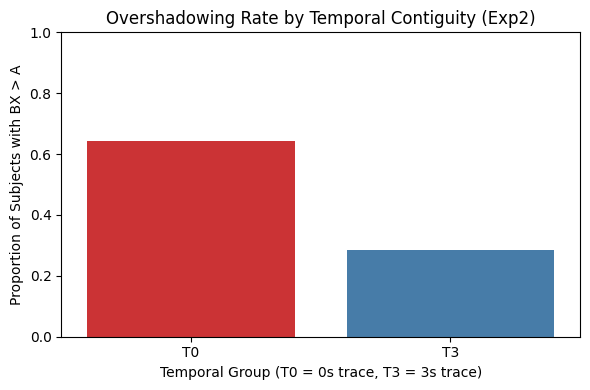

{'Overshadowing_Rate': {'T0': 0.6428571428571429, 'T3': 0.2857142857142857},
 'Classification_Report': {'0': {'precision': 1.0,
   'recall': 0.8,
   'f1-score': 0.8888888888888888,
   'support': 5.0},
  '1': {'precision': 0.8,
   'recall': 1.0,
   'f1-score': 0.8888888888888888,
   'support': 4.0},
  'accuracy': 0.8888888888888888,
  'macro avg': {'precision': 0.9,
   'recall': 0.9,
   'f1-score': 0.8888888888888888,
   'support': 9.0},
  'weighted avg': {'precision': 0.911111111111111,
   'recall': 0.8888888888888888,
   'f1-score': 0.8888888888888888,
   'support': 9.0}},
 'Confusion_Matrix': [[4, 1], [0, 4]],
 'Feature_Importances': {'Temporal_Group_Code': np.float64(0.03771781027614361),
  'A_mean': np.float64(0.2949941150028752),
  'BX_mean': np.float64(0.2941612782656723),
  'A_trace': np.float64(0.17511784690750115),
  'BX_trace': np.float64(0.19800894954780765)}}

In [ ]:
# TEMPORAL

# 1. Overshadowing frequency by temporal group (T0 vs T3)
overshadowing_freq = df2_clean.groupby("Temporal_Group")["Overshadowing"].mean().reset_index()
overshadowing_freq.columns = ["Temporal_Group", "Overshadowing_Rate"]

# 2. Train classifier to predict overshadowing
df2_model = df2_clean.copy()
le = LabelEncoder()
df2_model["Temporal_Group_Code"] = le.fit_transform(df2_model["Temporal_Group"])

X_temporal = df2_model[["Temporal_Group_Code", "A_mean", "BX_mean", "A_trace", "BX_trace"]]
y_temporal = df2_model["Overshadowing"]

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_temporal, y_temporal, stratify=y_temporal, test_size=0.3, random_state=42)

clf_temporal = RandomForestClassifier(n_estimators=100, random_state=42)
clf_temporal.fit(X_train_t, y_train_t)
y_pred_t = clf_temporal.predict(X_test_t)

temporal_report = classification_report(y_test_t, y_pred_t, output_dict=True)
temporal_matrix = confusion_matrix(y_test_t, y_pred_t)
temporal_importances = dict(zip(X_temporal.columns, clf_temporal.feature_importances_))

# 3. Visualization: Overshadowing Rate
plt.figure(figsize=(6, 4))
sns.barplot(data=overshadowing_freq, x="Temporal_Group", y="Overshadowing_Rate", palette="Set1")
plt.title("Overshadowing Rate by Temporal Contiguity (Exp2)")
plt.ylabel("Proportion of Subjects with BX > A")
plt.xlabel("Temporal Group (T0 = 0s trace, T3 = 3s trace)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

{
    "Overshadowing_Rate": overshadowing_freq.set_index("Temporal_Group").to_dict()["Overshadowing_Rate"],
    "Classification_Report": temporal_report,
    "Confusion_Matrix": temporal_matrix.tolist(),
    "Feature_Importances": temporal_importances
}


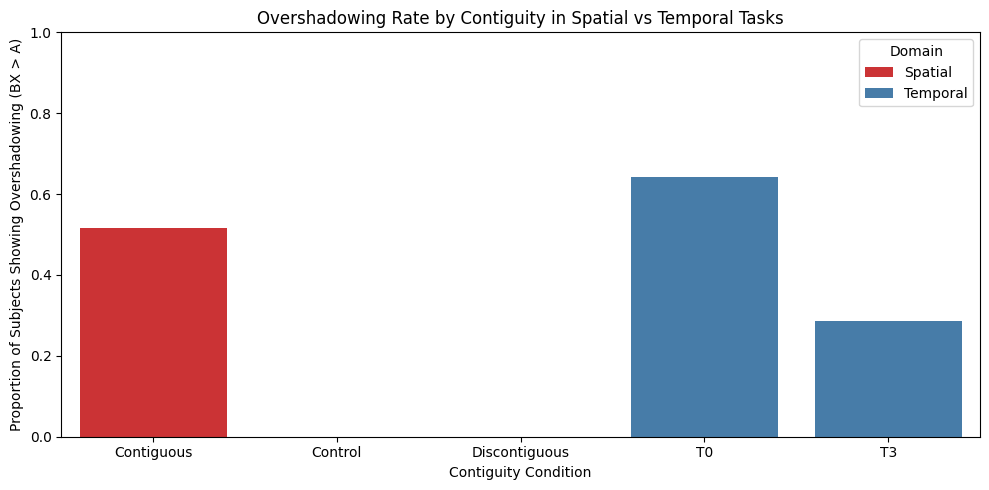

In [33]:
# Use previous spatial overshadowing labels and groupings
spatial_summary = spatial_theory_labeled.copy()

# Group and calculate overshadowing rate per contiguity type
spatial_plot_data = spatial_summary.groupby("Contiguity")["Overshadowing_GT"].mean().reset_index()
spatial_plot_data.columns = ["Condition", "Overshadowing Rate"]
spatial_plot_data["Domain"] = "Spatial"

# Temporal (Exp2) overshadowing rates from earlier
temporal_plot_data = df2_clean.groupby("Temporal_Group")["Overshadowing"].mean().reset_index()
temporal_plot_data.columns = ["Condition", "Overshadowing Rate"]
temporal_plot_data["Domain"] = "Temporal"

# Combine both for side-by-side plot
combined_plot_data = pd.concat([spatial_plot_data, temporal_plot_data], ignore_index=True)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=combined_plot_data, x="Condition", y="Overshadowing Rate", hue="Domain", palette="Set1")
plt.title("Overshadowing Rate by Contiguity in Spatial vs Temporal Tasks")
plt.ylabel("Proportion of Subjects Showing Overshadowing (BX > A)")
plt.xlabel("Contiguity Condition")
plt.ylim(0, 1)
plt.legend(title="Domain")
plt.tight_layout()
plt.show()


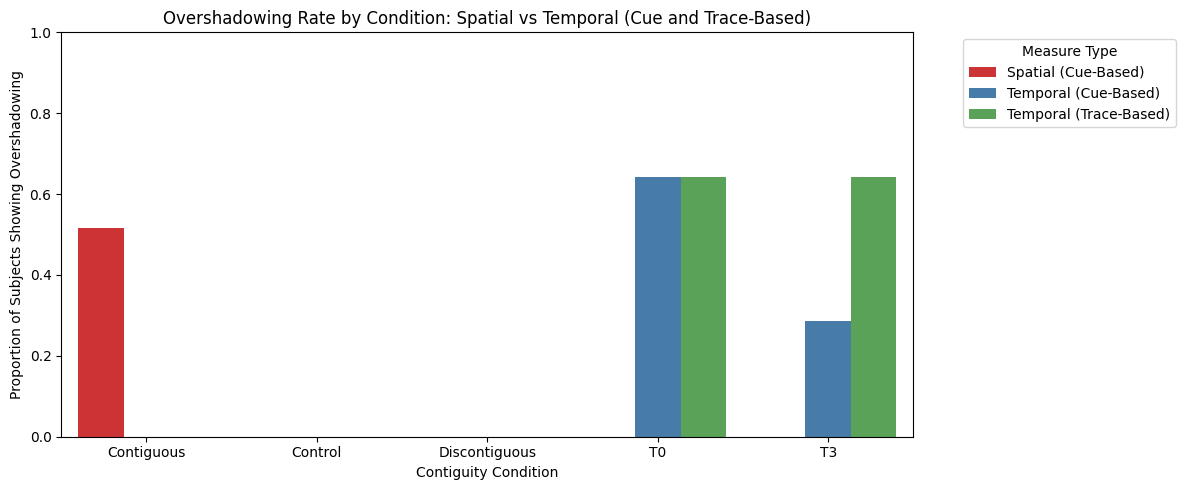

In [ ]:
# Calculate overshadowing based on trace response: BX_trace > A_trace 

# Spatial dataset does not include trace-based signals; limit this to temporal (Exp2)
df2_trace_based = df2_clean.copy()
df2_trace_based["Overshadowing_Trace"] = (df2_trace_based["BX_trace"] > df2_trace_based["A_trace"]).astype(int)

# Summarize temporal trace-based overshadowing rate
temporal_trace_plot_data = df2_trace_based.groupby("Temporal_Group")["Overshadowing_Trace"].mean().reset_index()
temporal_trace_plot_data.columns = ["Condition", "Overshadowing Rate"]
temporal_trace_plot_data["Domain"] = "Temporal (Trace-Based)"

# Merge with original spatial and temporal cue-based data
combined_trace_plot_data = pd.concat([
    spatial_plot_data.assign(Domain="Spatial (Cue-Based)"),
    temporal_plot_data.assign(Domain="Temporal (Cue-Based)"),
    temporal_trace_plot_data
], ignore_index=True)

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(data=combined_trace_plot_data, x="Condition", y="Overshadowing Rate", hue="Domain", palette="Set1")
plt.title("Overshadowing Rate by Condition: Spatial vs Temporal (Cue and Trace-Based)")
plt.ylabel("Proportion of Subjects Showing Overshadowing")
plt.xlabel("Contiguity Condition")
plt.ylim(0, 1)
plt.legend(title="Measure Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# merge spatial and temporal datasets for combined modeling

# Prepare spatial dataset 
spatial_model = spatial_theory_labeled.copy()
spatial_model = spatial_model.rename(columns={
    "Overshadowing_GT": "Overshadowing",
    "Contiguity": "Contiguity_Group"
})
spatial_model["Domain"] = "Spatial"
spatial_model = spatial_model[["Experiment", "Group", "Contiguity_Group", "Landmark_Size", "Mean_Training", "Test_Score", "Overshadowing", "Domain"]]

# Prepare temporal dataset
temporal_model = df2_clean.copy()
temporal_model["Contiguity_Group"] = temporal_model["Temporal_Group"]
temporal_model["Landmark_Size"] = "NA"
temporal_model["Group"] = temporal_model["Temporal_Group"]
temporal_model["Mean_Training"] = temporal_model[["A_mean", "BX_mean"]].mean(axis=1)
temporal_model["Test_Score"] = temporal_model[["A_trace", "BX_trace"]].mean(axis=1)
temporal_model["Domain"] = "Temporal"
temporal_model = temporal_model[["Experiment", "Group", "Contiguity_Group", "Landmark_Size", "Mean_Training", "Test_Score", "Overshadowing", "Domain"]]

# Combine datasets
combined_model_data = pd.concat([spatial_model, temporal_model], ignore_index=True)

# Encode categorical variables
le_contiguity = LabelEncoder()
le_landmark = LabelEncoder()
le_domain = LabelEncoder()

combined_model_data["Contiguity_Code"] = le_contiguity.fit_transform(combined_model_data["Contiguity_Group"])
combined_model_data["Landmark_Code"] = le_landmark.fit_transform(combined_model_data["Landmark_Size"])
combined_model_data["Domain_Code"] = le_domain.fit_transform(combined_model_data["Domain"])

# Features and target
X_combined = combined_model_data[["Contiguity_Code", "Landmark_Code", "Mean_Training", "Test_Score", "Domain_Code"]]
y_combined = combined_model_data["Overshadowing"]

# Train/test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_combined, y_combined, stratify=y_combined, test_size=0.3, random_state=42)

# Train classifier
clf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
clf_combined.fit(X_train_c, y_train_c)
y_pred_c = clf_combined.predict(X_test_c)

# Evaluate
combined_report = classification_report(y_test_c, y_pred_c, output_dict=True)
combined_matrix = confusion_matrix(y_test_c, y_pred_c)
combined_importances = dict(zip(X_combined.columns, clf_combined.feature_importances_))

{
    "Combined_Accuracy": combined_report["accuracy"],
    "Combined_Confusion_Matrix": combined_matrix.tolist(),
    "Combined_Feature_Importances": combined_importances
}


{'Combined_Accuracy': 0.925,
 'Combined_Confusion_Matrix': [[62, 4], [2, 12]],
 'Combined_Feature_Importances': {'Contiguity_Code': np.float64(0.2043330159567069),
  'Landmark_Code': np.float64(0.3211949818925439),
  'Mean_Training': np.float64(0.22662709039844509),
  'Test_Score': np.float64(0.20768067202885757),
  'Domain_Code': np.float64(0.04016423972344656)}}